# **Imports**

In [ ]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import re
import math
import random

import nltk
from textblob import TextBlob
#nltk.download('vader_lexicon')
#!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

import scipy.stats as st
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

#!pip install opencv-python-headless
import matplotlib.pyplot as plt
import seaborn as sns

from statistics import mean

pd.options.mode.chained_assignment = None

import sys
#!{sys.executable} -m pip install wordcloud

In [ ]:
## Read the CSV files and assign them to DataFrames

# NOTE: Our group used Google Collaboratory to store and access our data files.
# Please modify the file pathway as necessary to access the same files.

books_df = pd.read_csv("BX-Books.csv")
ratings_df = pd.read_csv("BX-Ratings.csv")
users_df = pd.read_csv("BX-Users.csv")
ISBN_df = pd.read_csv("ISBN-Directory.csv")

# from google.colab import drive
# drive.mount('/content/drive')

# books_df = pd.read_csv('/content/drive/MyDrive/COMP20008 Assignment 2/COMP20008-A2-Data-Files/BX-Books.csv')
# ratings_df = pd.read_csv('/content/drive/MyDrive/COMP20008 Assignment 2/COMP20008-A2-Data-Files/BX-Ratings.csv')
# users_df = pd.read_csv('/content/drive/MyDrive/COMP20008 Assignment 2/COMP20008-A2-Data-Files/BX-Users.csv')
# ISBN_df = pd.read_csv('/content/drive/MyDrive/COMP20008 Assignment 2/Reubens Work for Report/tester.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# # Data Pre-processing

In [ ]:
def remove_quotes(df):
    ''' Function to remove quotation marks from book title '''

    for index, row in df.iterrows():
        if row['Book-Title'].startswith('"') and row['Book-Title'].endswith('"'):
            df.at[index, 'Book-Title'] = row['Book-Title'][1:-1]
    return df

def update_invalid_titles(df, ISBN_df):
    ''' Function to replace invalid dataset book titles with correct titles '''

    isbn_to_title = dict(zip(ISBN_df['ISBN'], ISBN_df['Book-Title']))

    for index, row in df.iterrows():
        title = row['Book-Title']
        if not is_valid_string(title):
            isbn = row['ISBN']
            valid_titles = df[(df['ISBN'] == isbn) &
                      (df['Book-Title'].apply(is_valid_string))]['Book-Title']
            if not valid_titles.empty:
                new_title = valid_titles.iloc[0]  # Choose the first valid title
                df.at[index, 'Book-Title'] = new_title
            else:
                if isbn in isbn_to_title:
                    new_title = isbn_to_title[isbn]
                    df.at[index, 'Book-Title'] = new_title
    return df

def is_valid_string(input_str):
    ''' Function to check if a string contains only alphanumeric/punctuation
    characters '''

    pattern = r'^[\w\s\d.,?!-:;\'\(\)\[\]@#$%&=+/\\>-]*$'
    if re.match(pattern, input_str):
        return True
    else:
        return False

def is_integer(text):
    ''' Function to check if a string represents an integer '''
    try:
        int(text)
        return True
    except ValueError:
        return False

def filter_improper_entries(df):
    ''' Function to filter out entries with improper book titles, authors,
    or non-integer values in User-ID, ISBN, or Book-Rating '''
    return df[df.apply(lambda x: is_valid_string(x['Book-Title'])
                                and is_valid_string(x['Book-Author'])
                                and is_integer(x['User-ID'])
                                and is_integer(x['Book-Rating']), axis=1)]

In [ ]:
def preprocess_dataframe(df):
  # Remove books with less than 1 rating
  df = df[df.groupby('ISBN')['Book-Rating'].transform('count') >= 1]

  # Remove book authors with less than 3 books
  author_counts = df['Book-Author'].value_counts()
  df = df[df['Book-Author'].isin(author_counts.index[author_counts >= 3])]

  # Remove book publishers with less than 5 books
  publisher_counts = df['Book-Publisher'].value_counts()
  df = df[df['Book-Publisher'].isin(publisher_counts.index[publisher_counts >= 5])]

  # Remove books with year of publication before 1750 and after 2024
  df = df[(df['Year-Of-Publication'] >= 1750) & (df['Year-Of-Publication'] <= 2024)]

  # Remove ratings made by users with only 1 rating
  df = df[df.groupby('User-ID')['Book-Rating'].transform('count') > 1]

  # Remove ratings where the user gives the same rating for every book
  df = df[df.groupby('User-ID')['Book-Rating'].transform('nunique') > 1]

  return df

In [ ]:
# Preprocessing the user dataframe

#Remove users with no data for country or age
users_df = users_df.dropna(subset=['User-Country', 'User-Age'])

# Remove the " occasionally found at the end of a country name
users_df["User-Country"] = users_df["User-Country"].str.rstrip('"')
users_df["User-Age"] = users_df["User-Age"].astype("str").str.rstrip('"')

# Convert into correct datatype
users_df["User-Age"] = users_df["User-Age"].astype(float).astype('Int64')

# Remove users with unreasonable ages
users_df = users_df[users_df['User-Age'].between(5, 100)]
print("Removed unreasonable ages:", len(users_df))

# Preprocessing the book dataframe

print("Number of initial books:", len(books_df))

#Remove unreasonable years of publication
books_df = books_df.loc[books_df['Year-Of-Publication'] > 1900]
books_df = books_df.loc[books_df['Year-Of-Publication'] < 2025]

# Remove quotes from book titles
books_df = remove_quotes(books_df)

# Update books with improper titles to their correct ones
books_df = update_invalid_titles(books_df, ISBN_df)

print("Number of final books:", len(books_df))

Removed unreasonable ages: 28503
Number of initial books: 18185
Number of final books: 17868


In [ ]:
# Merge the DataFrames
merged_data = pd.merge(ratings_df, books_df, on='ISBN', how='inner')
merged_data = pd.merge(merged_data, users_df, on='User-ID', how='inner')

print(f'merged length = {len(merged_data)}\n')

# Filter out entries with improper book titles, authors, or non-integer values
# in User-ID, ISBN, or Book-Rating
cleaned_data = filter_improper_entries(merged_data)
print(f'cleaned length = {len(cleaned_data)}\n')

# Preprocess dataframe
filtered_df = preprocess_dataframe(cleaned_data)

print(f'filtered_df length = {len(filtered_df)}\n')

merged length = 137454

cleaned length = 137040

filtered_df length = 115784



## Export Cleaned Data

In [ ]:
# # Export
cleaned_data.to_csv('/content/drive/MyDrive/COMP20008 Assignment 2/Cleaned Data/Data-Cleaned.csv', index=False)
filtered_df.to_csv('/content/drive/MyDrive/COMP20008 Assignment 2/Cleaned Data/Data-Cleaned-Filtered.csv', index=False)

# Import Cleaned Data

In [ ]:
# Import previously cleaned data
filtered_df = pd.read_csv('/content/drive/MyDrive/COMP20008 Assignment 2/Cleaned Data/Data-Cleaned-Filtered.csv')

# Trend Analysis and Visualisation

## User Demographic Analysis

[Text(0.5, 1.0, 'Age Distribution of Users of the Online Bookstore'),
 Text(0.5, 0, 'User Age'),
 Text(0, 0.5, 'Density')]

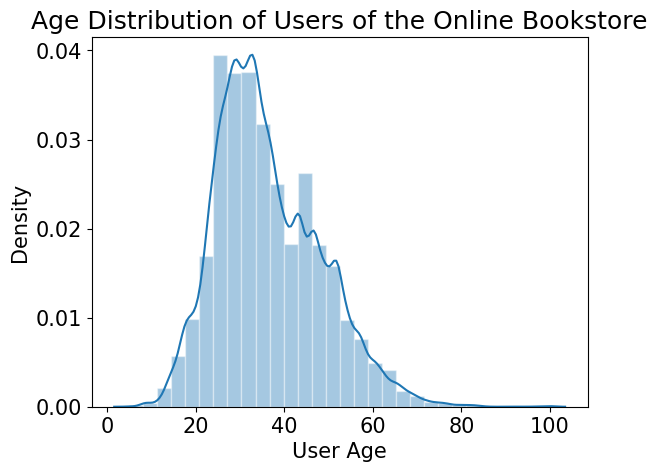

In [ ]:
# Distribution of User Age
sns.histplot(
    filtered_df['User-Age'], kde=True, bins=30,
    stat='density', kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
).set(
    title='Age Distribution of Users of the Online Bookstore',
    xlabel='User Age',
    ylabel='Density')

In [ ]:
# Percentage of users in each age group
print(filtered_df['User-Age'].value_counts(bins =[13,18,22,30,40,50,60,70,80,90,100], normalize=True).sort_index())

# 61% of users are between 20 and 40 years old
print(filtered_df['User-Age'].value_counts(bins =[20,40,60], normalize=True).sort_index())

User-Age
(12.999, 18.0]    0.034858
(18.0, 22.0]      0.048409
(22.0, 30.0]      0.268863
(30.0, 40.0]      0.319828
(40.0, 50.0]      0.188843
(50.0, 60.0]      0.103918
(60.0, 70.0]      0.026895
(70.0, 80.0]      0.004586
(80.0, 90.0]      0.000717
(90.0, 100.0]     0.000285
Name: proportion, dtype: float64
User-Age
(19.999, 40.0]    0.627626
(40.0, 60.0]      0.292761
Name: proportion, dtype: float64


## Book Publication Analysis

[Text(0.5, 1.0, 'Number of Publications by Year'),
 Text(0.5, 0, 'Year of Publication'),
 Text(0, 0.5, 'Density')]

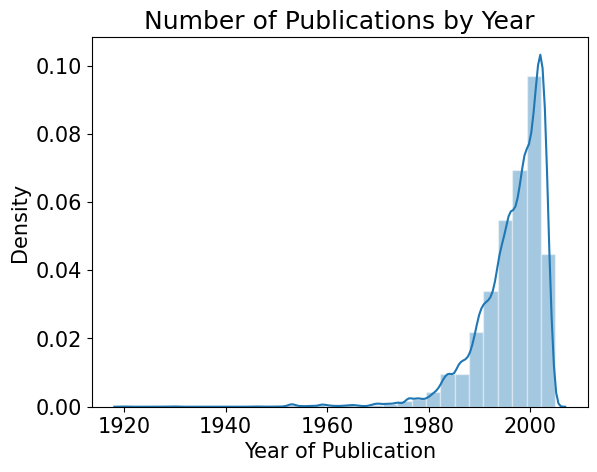

In [ ]:
# Distribution of the number of books published per year
sns.histplot(
    filtered_df['Year-Of-Publication'], kde=True, bins=30,
    stat='density', kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
).set(
    title='Number of Publications by Year',
    xlabel='Year of Publication',
    ylabel='Density')

# Popularity Analysis and Summary

In [ ]:
# Create a dataframe that describes each book and the ratings they received.
merged = pd.merge(ratings_df, users_df, on='User-ID', how='inner')
merged = merged.groupby(['ISBN']).aggregate(lambda x: tuple(x))
df2 = pd.merge(books_df, merged, on='ISBN', how='inner')

# Add analytical columns to new dataframe
df2['Count'] = df2['Book-Rating'].apply(len)
df2['Mean'] = df2['Book-Rating'].apply(mean)
df2["Years-In-Publication"] = df2["Year-Of-Publication"].apply(lambda x: 2024-x)
df2["Reviews-Per-Year"] = df2["Count"]/df2["Years-In-Publication"]

## Popularity analysis via Bayesian Average Method

In [ ]:
# Calculate the 90th quantile for number of reviews
m = df2['Count'].quantile(0.90)
# Calculate the mean review value for all books in the dataset
C = df2['Mean'].mean()

def get_bayesian_average(d, m=m, C=C):
  ''' Function that returns the bayesian average of the ratings
  of a certain book '''

  v = d['Count']
  R = d['Mean']

  return (v/(v+m)*R)+(m/(m+v)*C)

# Calculate the bayesian average for all books in dataframe
df2['Score']=df2.apply(get_bayesian_average, axis=1)

# Restrict the popularity ranking list to only books within the
# 90th percentile of total number of reviews
top = df2.loc[df2['Count']>=m]

# Print the top 10 most popular books according to this ranking
top.sort_values(by='Score', ascending=False)['Book-Title'].head(10)

2039     The Return of the King (The Lord of the Rings,...
2569          Harry Potter and the Goblet of Fire (Book 4)
1877     Harry Potter and the Prisoner of Azkaban (Book 3)
2602     Harry Potter and the Order of the Phoenix (Boo...
422         The Two Towers (The Lord of the Rings, Part 2)
1416        Harry Potter and the Sorcerer's Stone (Book 1)
15504    Harry Potter and the Chamber of Secrets Postca...
1117     Harry Potter and the Sorcerer's Stone (Harry P...
12                                   To Kill a Mockingbird
2969     Harry Potter and the Prisoner of Azkaban (Book 3)
Name: Book-Title, dtype: object

In [ ]:
print("Average rating: ", C)

Average rating:  7.749512818260691


[Text(0.5, 1.0, 'Age distribution of reviewers of The Return of the King (The Lord of the Rings, Part 3)'),
 Text(0.5, 0, 'User Age'),
 Text(0, 0.5, 'Density')]

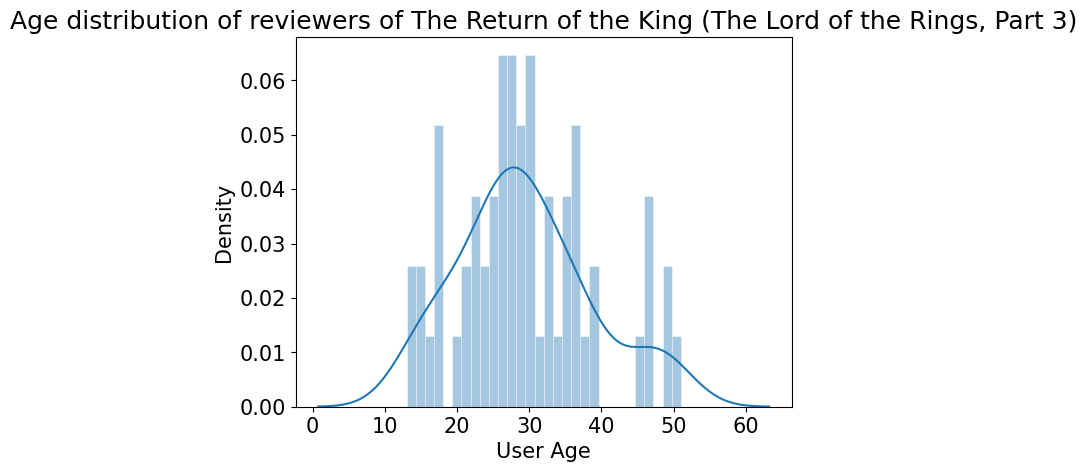

In [ ]:
# Graph the distribution of user ages of a given book
book_index = 0
book = top.sort_values('Score', ascending=False).iloc[book_index]
sns.histplot(
    book['User-Age'], kde=True, bins=30,
    stat='density', kde_kws=dict(cut=3),
    alpha=.4, edgecolor=(1, 1, 1, .4),
).set(
    title='Age distribution of reviewers of '+book['Book-Title'],
    xlabel='User Age',
    ylabel='Density')

In [ ]:
# The authors with the most books represented in the top rankings
top['Book-Author'].value_counts().head(10)

Book-Author
Stephen King          80
Nora Roberts          54
James Patterson       35
Dean R. Koontz        30
Mary Higgins Clark    26
John Grisham          20
Janet Evanovich       19
Sue Grafton           19
Anne Rice             18
Tom Clancy            18
Name: count, dtype: int64

## Top scores via Wilson Uncertainty

In [ ]:
def wilson_lower_bound(average_rating, n, confidence=0.95):
    ''' Weighs down ratings with fewer review counts due to uncertainty '''

    # No WLB if there are no reviews
    if n == 0:
        return 0

    # Calculate Z-score, default 1.96
    z = st.norm.ppf(1 - (1 - confidence) / 2)
    x_hat = (average_rating - 1) / 9

    # Wilson lower bound formula
    wlb = (
        x_hat + z*z/(2*n) - z *
        np.sqrt((x_hat *(1-x_hat)+z*z/(4*n))/n)
        )/(1+z*z/n)

    # Added 1 since minimum rating is 1
    return 1 + (9 * wlb)

def adjust_average(X):
    ''' Returns a new column with WLB-adjusted average rating scores '''

    # Create temporary copy of dataframe
    X = X[:]
    adjusted_averages = []

    # Calculate the WLB-adjusted average for each book in dataframe
    for i in range(len(X)):
        avg = X['Mean'].iloc[i]
        total = X['Count'].iloc[i]
        adjusted_averages.append(wilson_lower_bound(avg, total))

    X['Adjusted-Mean'] = adjusted_averages

    return X

# Calculate the WLB-adjusted average for all books
df2 = adjust_average(df2)

#df2.sort_values(by='Adjusted-Mean', ascending=True).head()

In [ ]:
# Restrict the popularity ranking list to only books within the
# 90th percentile of total number of reviews
top2 = df2.loc[df2['Count']>=m]

# Top 10 most popular books according to this ranking
top2.sort_values(by='Adjusted-Mean', ascending=False)['Book-Title'].head(10)

2569         Harry Potter and the Goblet of Fire (Book 4)
2039    The Return of the King (The Lord of the Rings,...
1877    Harry Potter and the Prisoner of Azkaban (Book 3)
2602    Harry Potter and the Order of the Phoenix (Boo...
1117    Harry Potter and the Sorcerer's Stone (Harry P...
1416       Harry Potter and the Sorcerer's Stone (Book 1)
12                                  To Kill a Mockingbird
422        The Two Towers (The Lord of the Rings, Part 2)
2969    Harry Potter and the Prisoner of Azkaban (Book 3)
834     The Fellowship of the Ring (The Lord of the Ri...
Name: Book-Title, dtype: object

In [ ]:
# The authors with the most books represented in the top rankings
top2['Book-Author'].value_counts().reset_index(name='Count').head(10)

,Book-Author,Count
0,Stephen King,80
1,Nora Roberts,54
2,James Patterson,35
3,Dean R. Koontz,30
4,Mary Higgins Clark,26
5,John Grisham,20
6,Janet Evanovich,19
7,Sue Grafton,19
8,Anne Rice,18
9,Tom Clancy,18


## Comparison of Popularity rankings

In [ ]:
pd.concat([top.sort_values(by='Score', ascending=False)['Book-Title'].reset_index(name='Title - Sorted by Bayesian Average'), top2.sort_values(by='Adjusted-Mean', ascending=False)['Book-Title'].reset_index(name='Title - Sorted by Wilsons Lower Bound')], axis=1, join='inner').head(10)

,index,Title - Sorted by Bayesian Average,index,Title - Sorted by Wilsons Lower Bound
0,2039,"The Return of the King (The Lord of the Rings,...",2569,Harry Potter and the Goblet of Fire (Book 4)
1,2569,Harry Potter and the Goblet of Fire (Book 4),2039,"The Return of the King (The Lord of the Rings,..."
2,1877,Harry Potter and the Prisoner of Azkaban (Book 3),1877,Harry Potter and the Prisoner of Azkaban (Book 3)
3,2602,Harry Potter and the Order of the Phoenix (Boo...,2602,Harry Potter and the Order of the Phoenix (Boo...
4,422,"The Two Towers (The Lord of the Rings, Part 2)",1117,Harry Potter and the Sorcerer's Stone (Harry P...
5,1416,Harry Potter and the Sorcerer's Stone (Book 1),1416,Harry Potter and the Sorcerer's Stone (Book 1)
6,15504,Harry Potter and the Chamber of Secrets Postca...,12,To Kill a Mockingbird
7,1117,Harry Potter and the Sorcerer's Stone (Harry P...,422,"The Two Towers (The Lord of the Rings, Part 2)"
8,12,To Kill a Mockingbird,2969,Harry Potter and the Prisoner of Azkaban (Book 3)
9,2969,Harry Potter and the Prisoner of Azkaban (Book 3),834,The Fellowship of the Ring (The Lord of the Ri...


# Correlation Visualiation


Text(0, 0.5, 'Year of Publication')

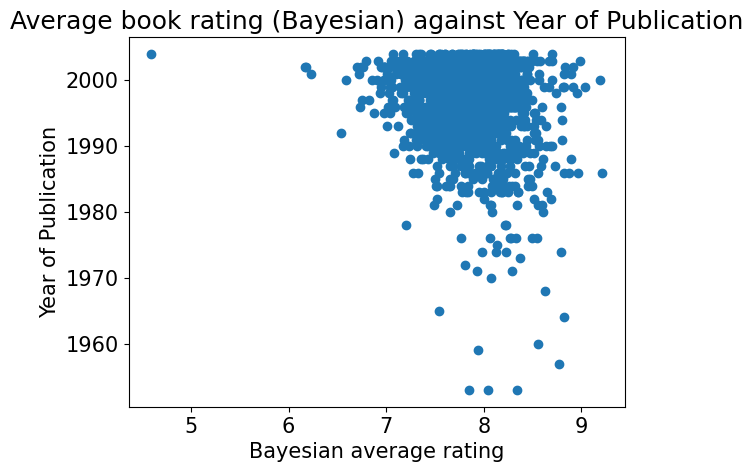

In [ ]:
# Plot Average book rating (Bayesian) against Year of Publication
plt.scatter(top['Score'], top['Year-Of-Publication'])
plt.title("Average book rating (Bayesian) against Year of Publication")
plt.xlabel("Bayesian average rating")
plt.ylabel("Year of Publication")

Text(0, 0.5, 'Year of Publication')

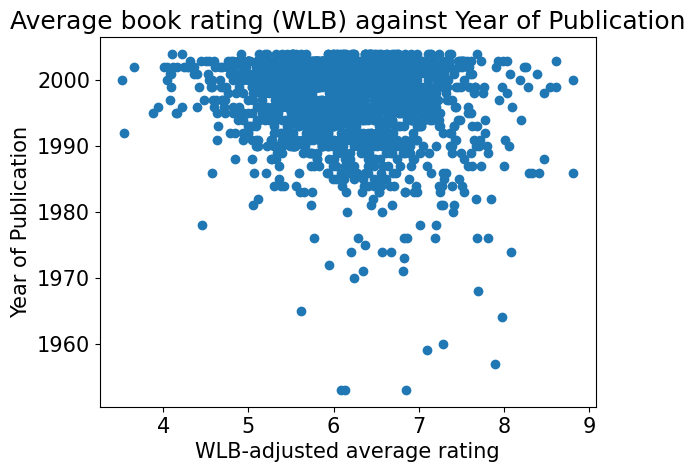

In [ ]:
# Plot Average book rating (WLB) against Year of Publication
plt.scatter(top2['Adjusted-Mean'], top2['Year-Of-Publication'])
plt.title("Average book rating (WLB) against Year of Publication")
plt.xlabel("WLB-adjusted average rating")
plt.ylabel("Year of Publication")

Text(0, 0.5, 'Bayesian average rating')

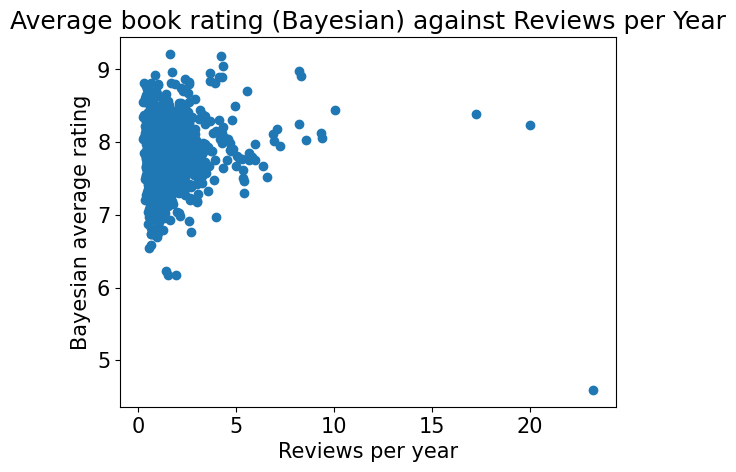

In [ ]:
# Plot Average book rating (Bayesian) against Reviews per Year
plt.scatter(top["Reviews-Per-Year"], top['Score'])
plt.title("Average book rating (Bayesian) against Reviews per Year")
plt.xlabel("Reviews per year")
plt.ylabel("Bayesian average rating")

Text(0, 0.5, 'WLB-adjusted everage rating')

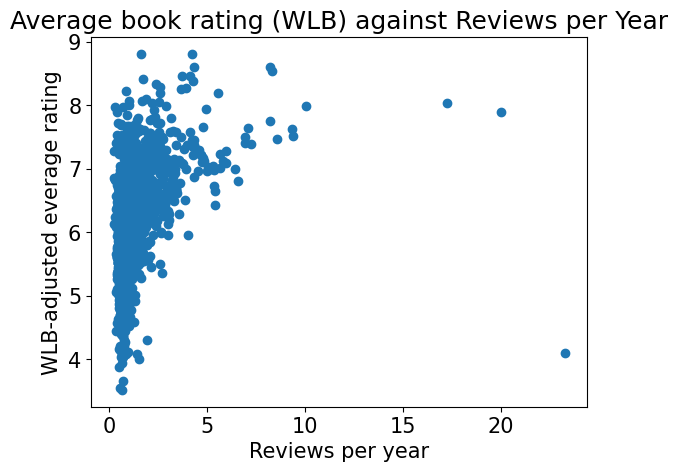

In [ ]:
# Plot Average book rating (WLB) against Reviews per Year
plt.scatter(top2["Reviews-Per-Year"], top2['Adjusted-Mean'])
plt.title("Average book rating (WLB) against Reviews per Year")
plt.xlabel("Reviews per year")
plt.ylabel("WLB-adjusted everage rating")

# Trying to analyse via user

In [ ]:
# Create a dataframe that describes each user and the ratings they made.
merged = pd.merge(ratings_df, books_df, on='ISBN', how='inner')
merged = merged.groupby(['User-ID']).aggregate(lambda x: tuple(x))
df3 = pd.merge(users_df, merged, on='User-ID', how='inner')
# Add analytical columns to new dataframe
df3['Count'] = df3['Book-Rating'].apply(len)
df3['Mean'] = df3['Book-Rating'].apply(mean)
# Calculate the Bayesian and WLB-adjusted average for all books
df3['Score']=df3.apply(get_bayesian_average, axis=1)
df3 = adjust_average(df3)

Text(0, 0.5, 'Average rating')

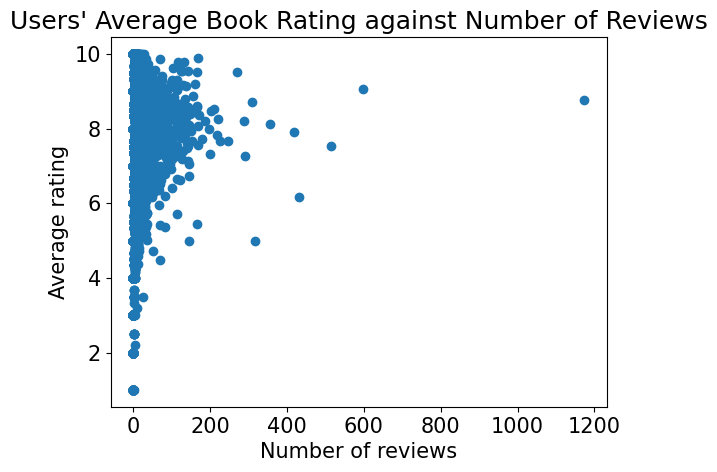

In [ ]:
# Plot Users' Average Book Rating against Number of Reviews
plt.scatter(df3["Count"], df3['Mean'])
plt.title("Users' Average Book Rating against Number of Reviews")
plt.xlabel("Number of reviews")
plt.ylabel("Average rating")

Text(0, 0.5, 'Bayesian average rating')

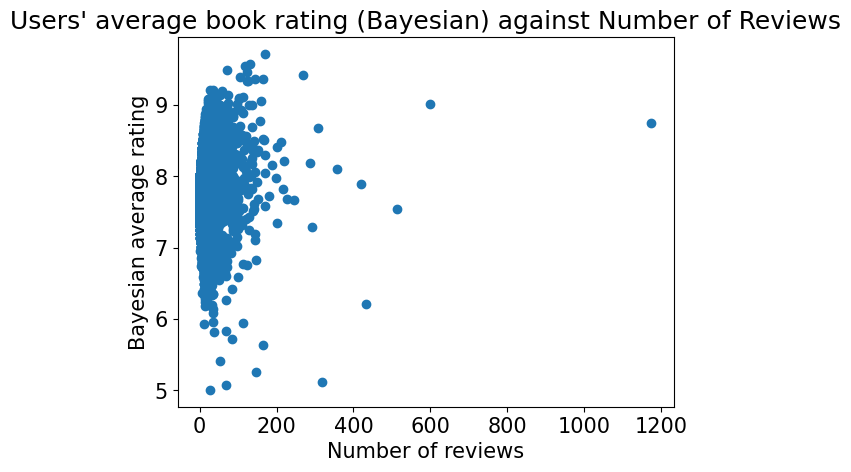

In [ ]:
# Plot Users' average book rating (Bayesian) against Number of Reviews
plt.scatter(df3["Count"], df3['Score'])
plt.title("Users' average book rating (Bayesian) against Number of Reviews")
plt.xlabel("Number of reviews")
plt.ylabel("Bayesian average rating")

Text(0, 0.5, 'WLB-adjusted average rating')

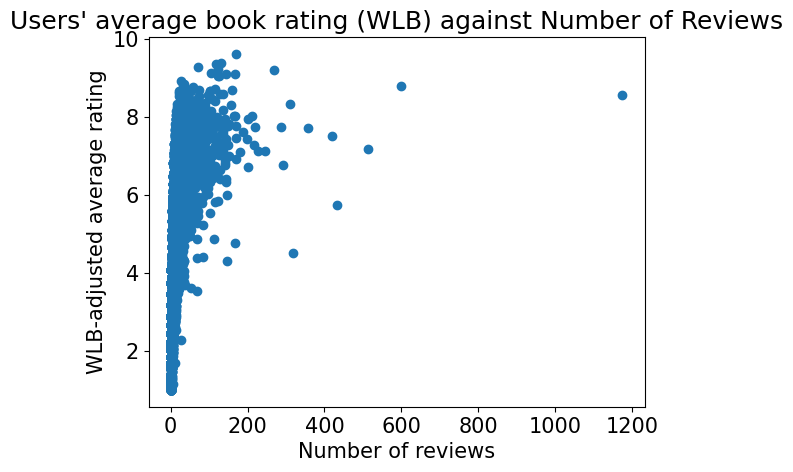

In [ ]:
# Plot Users' average book rating (Bayesian) against Number of Reviews
plt.scatter(df3["Count"], df3['Adjusted-Mean'])
plt.title("Users' average book rating (WLB) against Number of Reviews")
plt.xlabel("Number of reviews")
plt.ylabel("WLB-adjusted average rating")

# Sentiment Analysis

In [ ]:
# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

def calculate_sentiment_scores(title):
    scores = sid.polarity_scores(title)
    return scores

def calculate_textblob_sentiment(title):
    blob = TextBlob(title)
    return blob.sentiment.polarity

In [ ]:
# Calculate and filter sentiment scores by type
sentiment_scores = filtered_df['Book-Title'].apply(calculate_sentiment_scores)
filtered_df.loc[:, 'Sentiment-Negative'] = sentiment_scores.apply(lambda x: x['neg'])
filtered_df.loc[:, 'Sentiment-Neutral'] = sentiment_scores.apply(lambda x: x['neu'])
filtered_df.loc[:, 'Sentiment-Positive'] = sentiment_scores.apply(lambda x: x['pos'])
filtered_df.loc[:, 'TextBlob-Sentiment'] = df['Book-Title'].apply(calculate_textblob_sentiment)

#print(df.head(10))

## Visualisation of Results

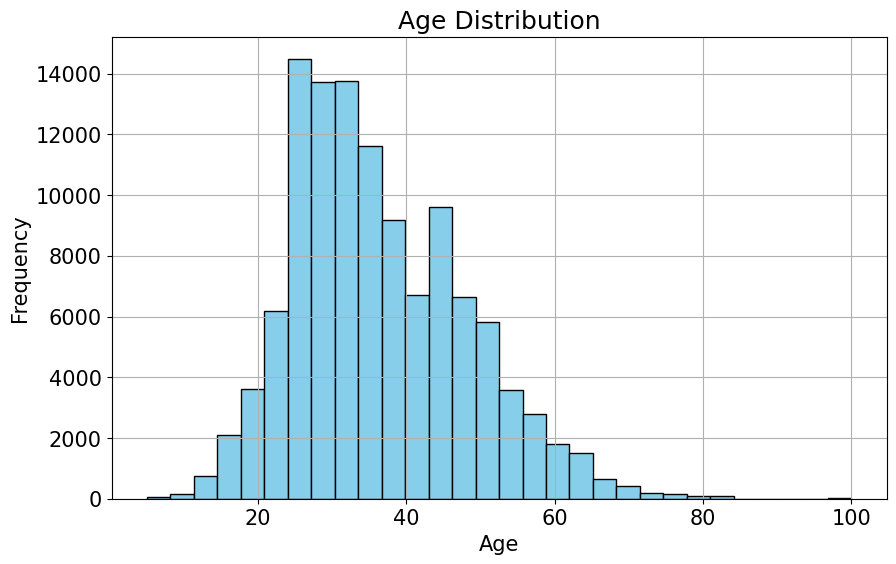

In [ ]:
filtered_df_clean = filtered_df.dropna(subset=['User-Age'])

# Convert 'User-Age' column to numeric type
filtered_df_clean['User-Age'] = pd.to_numeric(filtered_df_clean['User-Age'], errors='coerce')

# Drop rows with non-numeric values in 'User-Age' column
filtered_df_clean = filtered_df_clean.dropna(subset=['User-Age'])

# Histogram for Age Distribution
plt.figure(figsize=(10, 6))
plt.hist(filtered_df_clean['User-Age'], bins=30, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

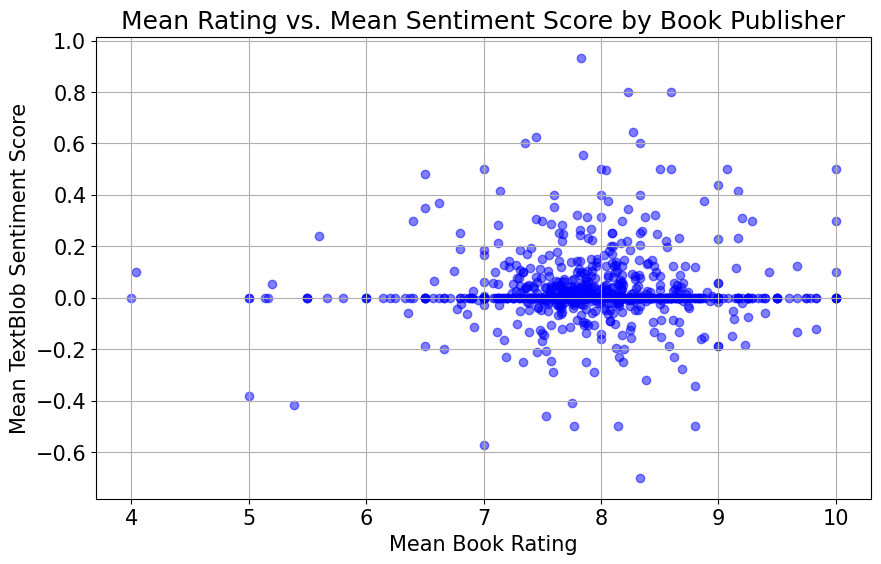

In [ ]:
# Calculate mean book rating and mean sentiment score for each book publisher
grouped_df = filtered_df.groupby('Book-Publisher').agg({
    'Book-Rating': 'mean',
    'TextBlob-Sentiment': 'mean'
}).reset_index()

grouped_df.columns = ['Book_Publisher', 'Mean-Book-Rating', 'Mean-TextBlob-Sentiment']

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(grouped_df['Mean-Book-Rating'], grouped_df['Mean-TextBlob-Sentiment'], color='blue', alpha=0.5)
plt.title('Mean Rating vs. Mean Sentiment Score by Book Publisher')
plt.xlabel('Mean Book Rating')
plt.ylabel('Mean TextBlob Sentiment Score')

# Add labels for each point
# for i, txt in enumerate(grouped_df['Book_Publisher']):
# plt.annotate(txt, (grouped_df['Mean-Book-Rating'][i], grouped_df['Mean-TextBlob-Sentiment'][i]))

plt.grid(True)
plt.show()

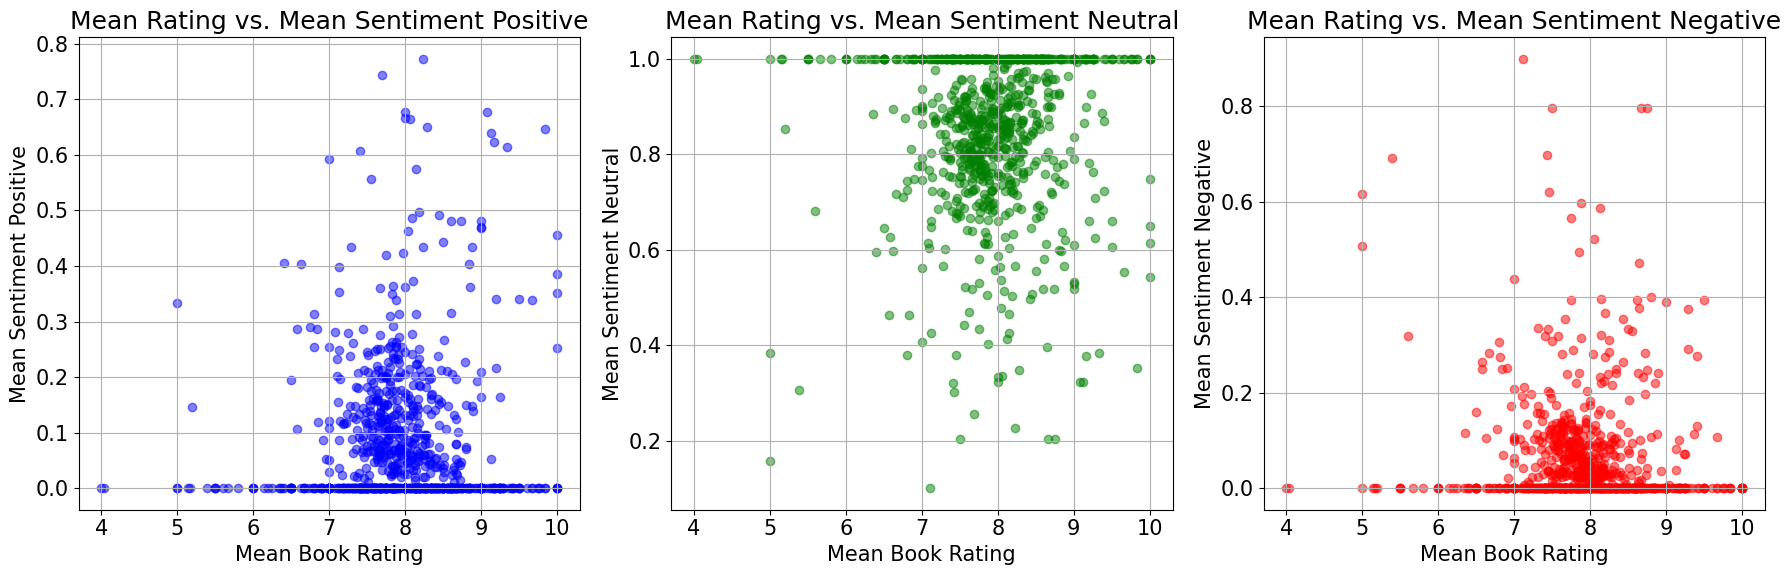

In [ ]:
# Calculate mean book rating and mean sentiment score for each book publisher
grouped_df = filtered_df.groupby('Book-Publisher').agg({
    'Book-Rating': 'mean',
    'Sentiment-Positive': 'mean',
    'Sentiment-Neutral': 'mean',
    'Sentiment-Negative': 'mean'
}).reset_index()

grouped_df.columns = ['Book_Publisher', 'Mean_Book_Rating', 'Mean_Sentiment_Positive', 'Mean_Sentiment_Neutral', 'Mean_Sentiment_Negative']

plt.figure(figsize=(18, 6))

# Plot for mean sentiment positive
plt.subplot(1, 3, 1)
plt.scatter(grouped_df['Mean_Book_Rating'], grouped_df['Mean_Sentiment_Positive'], color='blue', alpha=0.5)
plt.title('Mean Rating vs. Mean Sentiment Positive')
plt.xlabel('Mean Book Rating')
plt.ylabel('Mean Sentiment Positive')
plt.grid(True)

# Plot for mean sentiment neutral
plt.subplot(1, 3, 2)
plt.scatter(grouped_df['Mean_Book_Rating'], grouped_df['Mean_Sentiment_Neutral'], color='green', alpha=0.5)
plt.title('Mean Rating vs. Mean Sentiment Neutral')
plt.xlabel('Mean Book Rating')
plt.ylabel('Mean Sentiment Neutral')
plt.grid(True)

# Plot for mean sentiment negative
plt.subplot(1, 3, 3)
plt.scatter(grouped_df['Mean_Book_Rating'], grouped_df['Mean_Sentiment_Negative'], color='red', alpha=0.5)
plt.title('Mean Rating vs. Mean Sentiment Negative')
plt.xlabel('Mean Book Rating')
plt.ylabel('Mean Sentiment Negative')
plt.grid(True)

plt.tight_layout()
plt.show()

## Sentiment rating vs Age Group

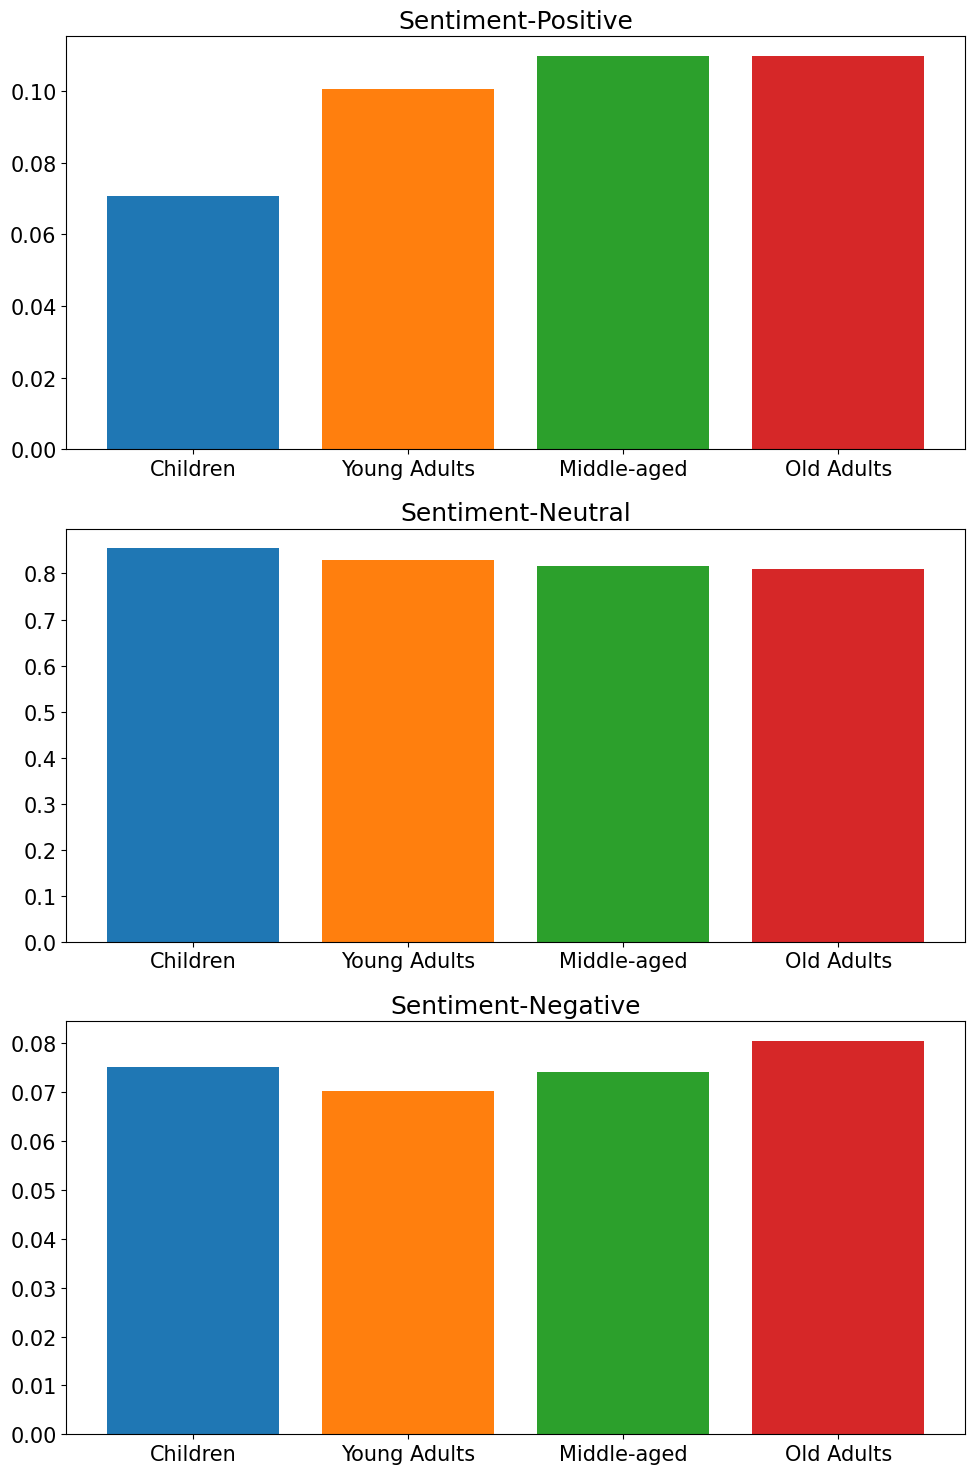

In [ ]:
def categorize_age(age):
    if 3 <= age <= 16:
        return 'Children'
    elif 17 <= age <= 30:
        return 'Young Adults'
    elif 31 <= age <= 45:
        return 'Middle-aged'
    else:
        return 'Old Adults'

filtered_df['Age-Range'] = filtered_df['User-Age'].apply(categorize_age)

age_range_order = ['Children', 'Young Adults', 'Middle-aged', 'Old Adults']
fig, axes = plt.subplots(3, 1, figsize=(10, 15))

sentiment_columns = ['Sentiment-Positive', 'Sentiment-Neutral', 'Sentiment-Negative']
for i, sentiment_col in enumerate(sentiment_columns):
    ax = axes[i]
    ax.set_title(sentiment_col)
    for age_range in age_range_order:
        group_df = filtered_df[filtered_df['Age-Range'] == age_range]
        ax.bar(age_range, group_df[sentiment_col].mean())

plt.tight_layout()
plt.show()

# Publisher Analysis

## Book-Publisher Grouping

In [ ]:
def xicor(X, Y, ties=True):
    ''' Function for Xi Correlation metric '''
    random.seed(42)
    n = len(X)
    order = np.array([i[0] for i in sorted(enumerate(X), key=lambda x: x[1])])
    if ties:
        l = np.array([sum(y >= Y[order]) for y in Y[order]])
        r = l.copy()
        for j in range(n):
            if sum([r[j] == r[i] for i in range(n)]) > 1:
                tie_index = np.array([r[j] == r[i] for i in range(n)])
                tie_values = r[tie_index] - np.arange(0, sum(tie_index))
                sampled_values = random.sample(list(tie_values), sum(tie_index))
                r[tie_index] = np.array(sampled_values)
        return 1 - n*np.sum( np.abs(r[1:] - r[:n-1]) ) / (2*np.sum(l*(n - l)))
    else:
        r = np.array([sum(y >= Y[order]) for y in Y[order]])
        return 1 - 3 * np.sum( np.abs(r[1:] - r[:n-1]) ) / (n**2 - 1)

def english_speaking_ratio(countries):
    ''' Function that calculates the ratio of reviewers from english versus
    non-english speaking countries '''
    english_speaking_countries = {'usa', 'canada', 'australia', 'ireland', 'new zealand', 'united kingdom'}
    total_countries = len(countries)
    english_speaking_count = sum(1 for country in countries if isinstance(country, str) and country.strip().lower() in english_speaking_countries)
    return english_speaking_count / total_countries if total_countries != 0 else 0

grouped = filtered_df.groupby('Book-Publisher')

# Retrieve data from grouped dataframe
average_user_age = grouped['User-Age'].mean()
average_year_of_publication = grouped['Year-Of-Publication'].mean()
most_popular_country = grouped['User-Country'].agg(lambda x: x.value_counts().index[0])
sentiment_counts = grouped[['Sentiment-Positive', 'Sentiment-Negative', 'Sentiment-Neutral']].sum()
most_frequent_sentiment = sentiment_counts.idxmax(axis=1)
average_rating = grouped['Book-Rating'].mean()  # Adding this line to calculate the average rating
english_speaking_ratio_column = grouped['User-Country'].agg(english_speaking_ratio)
textblob_sentiment = grouped['TextBlob-Sentiment'].mean()

# Create a dataframe summarising information of each publisher
publisher_df = pd.DataFrame({
    'Average User-Age': average_user_age,
    'Average Year-Of-Publication': average_year_of_publication,
    'Most Popular Country': most_popular_country,
    'Sentiment-Positive': sentiment_counts['Sentiment-Positive'],
    'Sentiment-Negative': sentiment_counts['Sentiment-Negative'],
    'Sentiment-Neutral': sentiment_counts['Sentiment-Neutral'],
    'Sentiment': most_frequent_sentiment,
    'Average Rating': average_rating,
    'English-Speaking-Ratio': english_speaking_ratio_column,
    'TextBlob-Sentiment': textblob_sentiment
}).reset_index()

print(publisher_df.head(10))

             Book-Publisher  Average User-Age  Average Year-Of-Publication  \
0                 A. Michel         36.428571                  1994.857143   
1              A. Mondadori         39.000000                  1993.500000   
2               ACE Charter         33.615702                  1995.082645   
3  AIMS International Books         26.375000                  1999.000000   
4                    Abacus         30.625000                  1997.625000   
5           Abbeville Press         33.800000                  1994.000000   
6        Acacia Press, Inc.         35.454545                  1992.272727   
7                 Ace Books         32.424078                  1996.348156   
8                 Actes Sud         31.071429                  1999.000000   
9   Adams Media Corporation         39.100000                  1999.850000   

  Most Popular Country  Sentiment-Positive  Sentiment-Negative  \
0               france               0.000               0.000   
1        

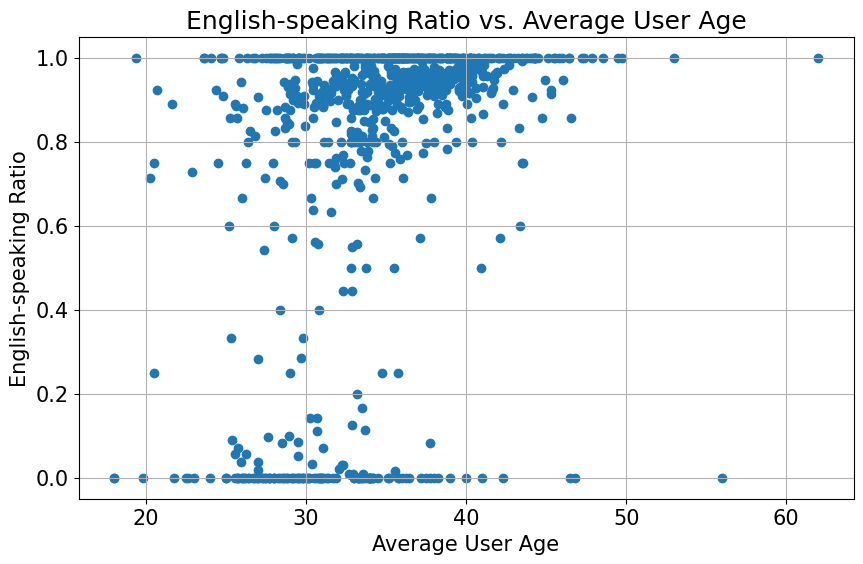

-0.1768


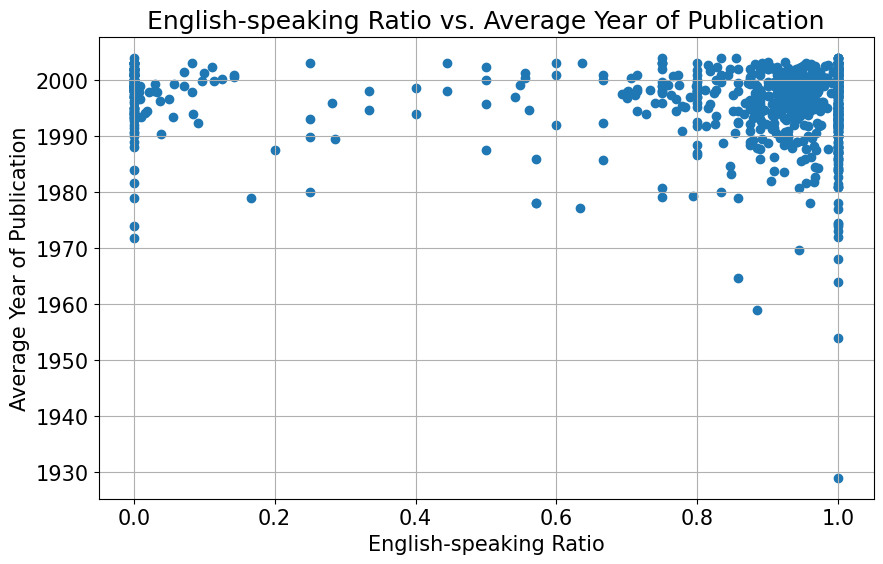

-0.1919


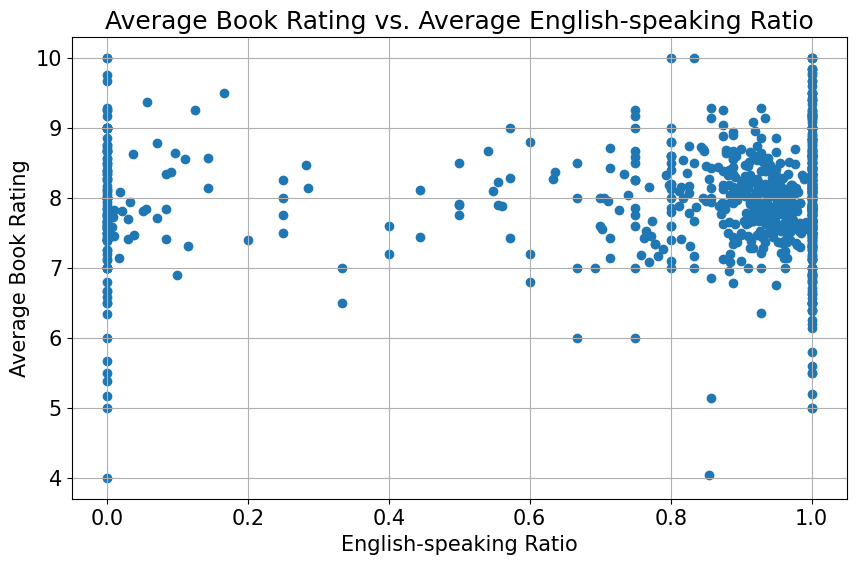

-0.2336


In [ ]:
# Plot the English-speaking Ratio vs. Average User Age per publisher
plt.figure(figsize=(10, 6))
plt.scatter(publisher_df['Average User-Age'], publisher_df['English-Speaking-Ratio'])
plt.title('English-speaking Ratio vs. Average User Age')
plt.xlabel('Average User Age')
plt.ylabel('English-speaking Ratio')
plt.grid(True)
plt.show()
average_age = publisher_df['Average User-Age']
english_speaking_ratio = publisher_df['English-Speaking-Ratio']
print(np.round(xicor(average_age , english_speaking_ratio, True), 4))

# Plot the English-speaking Ratio vs. Average Year of Publication per publisher
plt.figure(figsize=(10, 6))
plt.scatter(publisher_df['English-Speaking-Ratio'], publisher_df['Average Year-Of-Publication'])
plt.title('English-speaking Ratio vs. Average Year of Publication')
plt.xlabel('English-speaking Ratio')
plt.ylabel('Average Year of Publication')
plt.grid(True)
plt.show()
average_year = publisher_df['Average Year-Of-Publication']
english_speaking_ratio = publisher_df['English-Speaking-Ratio']
print(np.round(xicor(average_year , english_speaking_ratio, True), 4))

# Plot the Average Book Rating vs. Average English-speaking Ratio per publisher
plt.figure(figsize=(10, 6))
plt.scatter(publisher_df['English-Speaking-Ratio'], publisher_df['Average Rating'])
plt.title('Average Book Rating vs. Average English-speaking Ratio')
plt.xlabel('English-speaking Ratio')
plt.ylabel('Average Book Rating')
plt.grid(True)
plt.show()
average_rating = publisher_df['Average Rating']
english_speaking_ratio = publisher_df['English-Speaking-Ratio']
print(np.round(xicor(average_rating , english_speaking_ratio, True), 4))

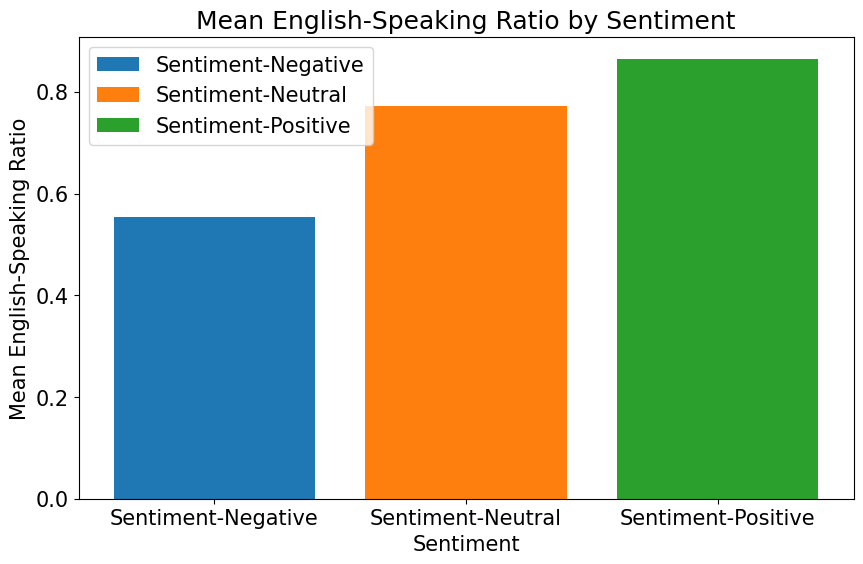

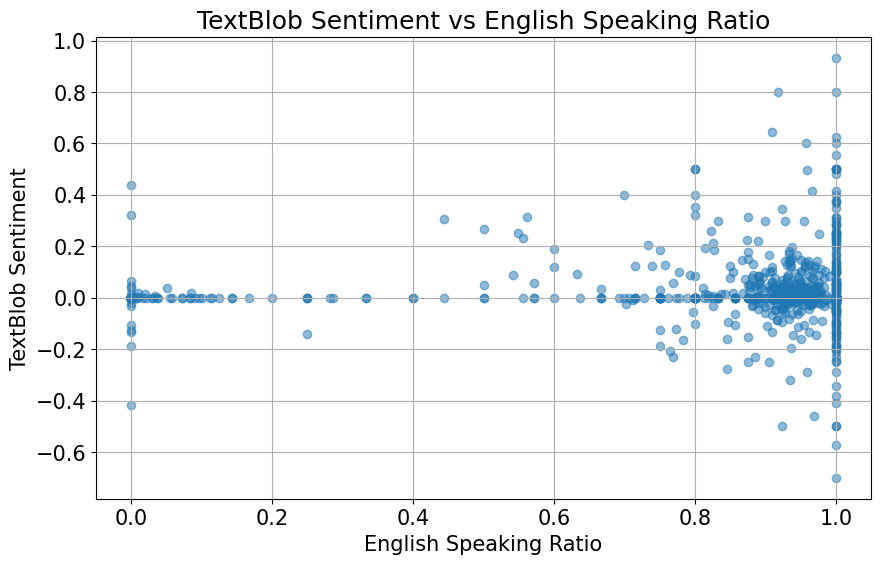

In [ ]:
# Get the Mean English-Speaking Ratio of each sentiment score
sentiment_english_ratio_mean = publisher_df.groupby('Sentiment')['English-Speaking-Ratio'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Iterate over each sentiment category and plot a histogram
for sentiment, english_ratio in sentiment_english_ratio_mean.items():
    plt.bar(sentiment, english_ratio, label=sentiment)

# Plot the Mean English-Speaking Ratio by Sentiment per publisher
plt.xlabel('Sentiment')
plt.ylabel('Mean English-Speaking Ratio')
plt.title('Mean English-Speaking Ratio by Sentiment')
plt.legend()
plt.show()

# Plot the TextBlob Sentiment vs English Speaking Ratio per publisher
plt.figure(figsize=(10, 6))
plt.scatter(publisher_df['English-Speaking-Ratio'], publisher_df['TextBlob-Sentiment'], alpha=0.5)
plt.title('TextBlob Sentiment vs English Speaking Ratio')
plt.xlabel('English Speaking Ratio')
plt.ylabel('TextBlob Sentiment')
plt.grid(True)
plt.show()

## Book Analysis

In [ ]:
def english_speaking_ratio(countries):
    english_speaking_countries = {'usa', 'canada', 'australia', 'ireland', 'new zealand', 'united kingdom'}
    total_countries = len(countries)
    english_speaking_count = sum(1 for country in countries if isinstance(country, str) and country.strip().lower() in english_speaking_countries)
    return english_speaking_count / total_countries if total_countries != 0 else 0

def create_booklist_df(filtered_df):
    # Calculate average book rating, average user age, and English speaking ratio
    booklist_df = filtered_df.groupby('ISBN').agg({
        'Book-Title': 'first',
        'Book-Author': 'first',
        'Year-Of-Publication': 'first',
        'Book-Publisher': 'first',
        'Book-Rating': ['mean', 'count'],
        'User-Age': 'mean',
        'User-Country': lambda x: english_speaking_ratio(x),
        'Sentiment-Negative': 'first',
        'Sentiment-Neutral': 'first',
        'Sentiment-Positive': 'first',
    }).reset_index()

    # Rename columns
    booklist_df.columns = ['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Book-Publisher',
                           'Average-Book-Rating', 'Number-Of-Ratings', 'Average-User-Age',
                           'English-Speaking-Ratio', 'Sentiment-Negative', 'Sentiment-Neutral',
                           'Sentiment-Positive']

    return booklist_df

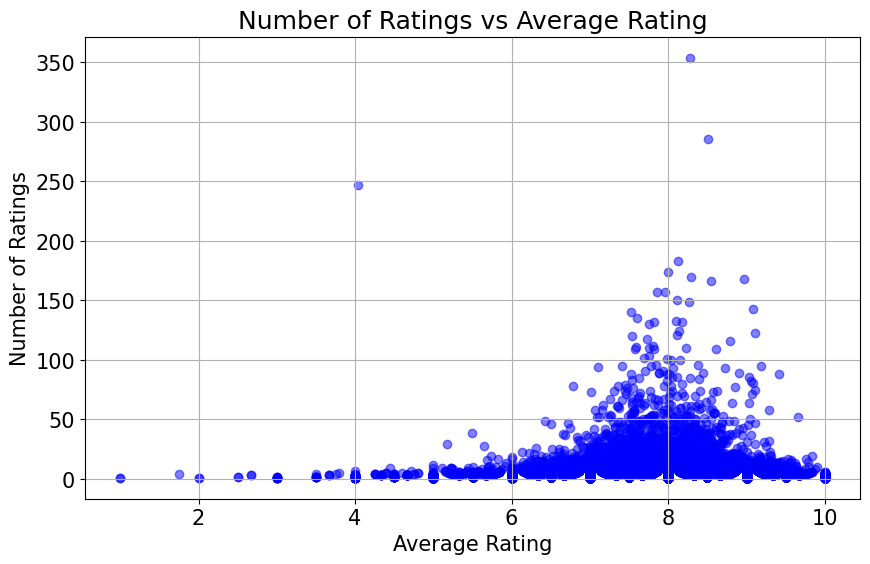

In [ ]:
booklist_df = create_booklist_df(filtered_df)

ratings = booklist_df['Average-Book-Rating']
num_ratings = booklist_df['Number-Of-Ratings']

# Creating scatterplot
plt.figure(figsize=(10, 6))
plt.scatter(ratings, num_ratings, color='blue', alpha=0.5)

# Adding labels and title
plt.title('Number of Ratings vs Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Number of Ratings')

# Adding grid
plt.grid(True)

# Displaying plot
plt.show()

In [124]:
# NOTE: This cell takes approximately 20 minutes to run.

pts_x = np.array(booklist_df['Average-User-Age'])
pts_y = np.array(booklist_df['English-Speaking-Ratio'])

RESOLUTION = 50
LOCALITY = 2.0

dx = max(pts_x) - min(pts_x)
dy = max(pts_y) - min(pts_y)
delta = min(dx, dy) / RESOLUTION
nx = int(dx / delta)
ny = int(dy / delta)
radius = (1 / LOCALITY) * min(dx, dy)

grid_x = np.linspace(min(pts_x), max(pts_x), num=nx)
grid_y = np.linspace(min(pts_y), max(pts_y), num=ny)
x, y = np.meshgrid(grid_x, grid_y, indexing='ij')

def gauss(x1, x2, y1, y2):
    '''
    Apply a Gaussian kernel estimation (2-sigma) to distance between points.
    '''
    return (
        (1.0 / (2.0 * math.pi))
        * math.exp(
            -1 * (3.0 * math.sqrt((x1 - x2)**2 + (y1 - y2)**2) / radius))**2
        / 0.4)


def _kde(x, y):
    '''
    Estimate the kernel density at a given position.
    '''
    return sum([
        gauss(x, px, y, py)
        for px, py in zip(pts_x, pts_y)
    ])


kde = np.vectorize(_kde)
z = kde(x, y)

xi, yi = np.where(z == np.amax(z))
max_x = grid_x[xi][0]
max_y = grid_y[yi][0]

# Printing the coordinates of the highest point of density
print("Coordinates of the highest point of density:")
print("X-coordinate:", max_x)
print("Y-coordinate:", max_y)

# Plotting density plot
fig, ax = plt.subplots()
pcm = ax.pcolormesh(x, y, z, cmap='inferno', vmin=np.min(z), vmax=np.max(z))
fig.colorbar(pcm, ax=ax, label='Density')
ax.set_title('Density Plot')
ax.set_xlabel('Average User Age')
ax.set_ylabel('English Speaking Ratio')
fig.set_size_inches(6, 6)
fig.savefig('density.png', bbox_inches='tight')

# Plotting scatter plot with marked point
fig, ax = plt.subplots()
ax.scatter(pts_x, pts_y, marker='+', color='blue', label='Data Points')
ax.scatter(max_x, max_y, marker='+', color='red', s=200, label='Max Density')
ax.set_title('Scatter Plot with Max Density')
ax.set_xlabel('Average User Age')
ax.set_ylabel('English Speaking Ratio')
ax.legend()
fig.set_size_inches(6, 6)
fig.savefig('marked.png', bbox_inches='tight')

plt.show()


KeyboardInterrupt: 

In [ ]:
mean_number_of_ratings = booklist_df['Number-Of-Ratings'].mean()

print("Mean Number of Ratings:", mean_number_of_ratings)

threshold = mean_number_of_ratings

x_ranges = []
y_ranges = []

for i in range(nx):
    for j in range(ny):
        if z[i, j] > threshold:
            x_min = grid_x[i]
            x_max = grid_x[i+1] if i+1 < nx else max(pts_x)
            y_min = grid_y[j]
            y_max = grid_y[j+1] if j+1 < ny else max(pts_y)
            x_ranges.append((x_min, x_max))
            y_ranges.append((y_min, y_max))

# Printing the ranges of high-density regions
if x_ranges:
    print("X ranges:")
    print(f"Lowest X value: {min(x_ranges, key=lambda x: x[0])[0]}")
    print(f"Highest X value: {max(x_ranges, key=lambda x: x[1])[1]}")
    print()

if y_ranges:
    print("Y ranges:")
    print(f"Lowest Y value: {min(y_ranges, key=lambda y: y[0])[0]}")
    print(f"Highest Y value: {max(y_ranges, key=lambda y: y[1])[1]}")
    print()

In [ ]:
center_x = 35.82013669821241
center_y = 0.8339020854243337
a = 14.422397476340691 / 2
b = 0.3555481208876993 / 2

theta = np.linspace(0, 2*np.pi, 100)
x = center_x + a * np.cos(theta)
y = center_y + b * np.sin(theta)

fig, ax = plt.subplots()
ax.scatter(pts_x, pts_y, marker='+', color='blue', label='Data Points')
ax.scatter(max_x, max_y, marker='+', color='red', s=200, label='Max Density')
ax.plot(x, y, color='red', label='Oval Fit')  # Changing the oval color to red
ax.set_title('Scatter Plot with Max Density and Oval Fit')
ax.set_xlabel('Average User Age')
ax.set_ylabel('English Speaking Ratio')
ax.legend()
fig.set_size_inches(6, 6)
fig.savefig('marked_with_red_oval.png', bbox_inches='tight')

plt.show()

In [ ]:
# English-speaking ratio vs number of ratings
plt.figure(figsize=(10, 6))
plt.scatter(booklist_df['English-Speaking-Ratio'], booklist_df['Number-Of-Ratings'], alpha=0.5)
plt.title('Number of Ratings vs English Speaking Ratio')
plt.xlabel('English Speaking Ratio')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.show()

filtered_books = booklist_df[(booklist_df['English-Speaking-Ratio'] >= 0.628) & (booklist_df['English-Speaking-Ratio'] < 0.984)]

# Count the number of books in the filtered DataFrame
num_books = len(filtered_books)

print("Number of books with English speaking ratio between [0.628, 0.984):", num_books)

total_books = len(booklist_df)

print("Total number of books:", total_books)

In [ ]:
def parabolic_func(x, a, b, c):
    '''
    Return a parabola
    '''
    return a * x**2 + b * x + c

non_english = booklist_df[booklist_df['English-Speaking-Ratio'] < 1]
non_zero_english = non_english[non_english['English-Speaking-Ratio'] > 0]
x_data = non_zero_english['English-Speaking-Ratio']
y_data = non_zero_english['Number-Of-Ratings']

Q1 = np.percentile(y_data, 25)
Q3 = np.percentile(y_data, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

non_outliers = non_zero_english[(non_zero_english['Number-Of-Ratings'] >= lower_bound) & (non_zero_english['Number-Of-Ratings'] <= upper_bound)]
x_non_outliers = non_outliers['English-Speaking-Ratio']
y_non_outliers = non_outliers['Number-Of-Ratings']

popt, pcov = curve_fit(parabolic_func, x_non_outliers, y_non_outliers)

y_predicted = parabolic_func(x_non_outliers, *popt)
residuals = y_non_outliers - y_predicted
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_non_outliers - np.mean(y_non_outliers))**2)
r_squared = 1 - (ss_res / ss_tot)
adjusted_r_squared = 1 - (1 - r_squared) * (len(y_non_outliers) - 1) / (len(y_non_outliers) - 3 - 1)

# Plot the parabola-fitted data
plt.figure(figsize=(10, 6))
plt.scatter(x_non_outliers, y_non_outliers, alpha=0.5, label='Non-Outlier Data')
x_range = np.linspace(min(x_non_outliers), max(x_non_outliers), 100)
plt.plot(x_range, parabolic_func(x_range, *popt), color='red', label='Parabolic Regression')

plt.title('Number of Ratings (Non-Outliers) vs English Speaking Ratio')
plt.xlabel('English Speaking Ratio')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.legend()
plt.show()

print("Parabolic regression parameters (a, b, c):", popt)
print("Adjusted R-squared score:", adjusted_r_squared)

In [ ]:
# Create boxplots
boxplot_data = booklist_df[(booklist_df['English-Speaking-Ratio'] >= 0.628) & (booklist_df['English-Speaking-Ratio'] < 0.984)]
boxplot_data_ratio_1 = booklist_df[booklist_df['English-Speaking-Ratio'] > 0.984]

plt.figure(figsize=(10, 6))

# First boxplot
box1 = plt.boxplot(booklist_df['Number-Of-Ratings'], positions=[1], widths=0.6)
plt.ylabel('Number of Ratings')

# Second boxplot
box2 = plt.boxplot(boxplot_data['Number-Of-Ratings'], positions=[2], widths=0.6)

# Third boxplot
box3 = plt.boxplot(boxplot_data_ratio_1['Number-Of-Ratings'], positions=[3], widths=0.6)

outliers1 = box1['fliers'][0].get_data()[1]
percentage_outliers1 = len(outliers1) / len(booklist_df['Number-Of-Ratings']) * 100
average_outliers1 = sum(outliers1) / len(outliers1)
print(f"Percentage of outliers for first boxplot: {percentage_outliers1:.2f}%")
print(f"Average value of outliers for first boxplot: {average_outliers1:.2f}")
lower_quartile1 = box1['whiskers'][0].get_ydata()[1]
upper_quartile1 = box1['whiskers'][1].get_ydata()[1]
print("Lower Quartile for first boxplot:", lower_quartile1)
print("Upper Quartile for first boxplot:", upper_quartile1)
print("\n")

outliers2 = box2['fliers'][0].get_data()[1]
percentage_outliers2 = len(outliers2) / len(boxplot_data['Number-Of-Ratings']) * 100
average_outliers2 = sum(outliers2) / len(outliers2)
print(f"Percentage of outliers for second boxplot: {percentage_outliers2:.2f}%")
print(f"Average value of outliers for second boxplot: {average_outliers2:.2f}")
lower_quartile2 = box2['whiskers'][0].get_ydata()[1]
upper_quartile2 = box2['whiskers'][1].get_ydata()[1]
print("Lower Quartile for second boxplot:", lower_quartile2)
print("Upper Quartile for second boxplot:", upper_quartile2)
print("\n")

outliers3 = box3['fliers'][0].get_data()[1]
percentage_outliers3 = len(outliers3) / len(boxplot_data_ratio_1['Number-Of-Ratings']) * 100
average_outliers3 = sum(outliers3) / len(outliers3)
print(f"Percentage of outliers for third boxplot: {percentage_outliers3:.2f}%")
print(f"Average value of outliers for third boxplot: {average_outliers3:.2f}")
lower_quartile3 = box3['whiskers'][0].get_ydata()[1]
upper_quartile3 = box3['whiskers'][1].get_ydata()[1]
print("Lower Quartile for third boxplot:", lower_quartile3)
print("Upper Quartile for third boxplot:", upper_quartile3)

plt.xticks([1, 2, 3], ['English-Speaking Ratio [0.0, 0.628)', 'English-Speaking Ratio [0.628, 0.984)', 'English-Speaking Ratio > 0.984'])
plt.title('Comparison of Number of Ratings')
plt.show()


In [ ]:
def exponential_func(x, a, b):
    '''
    Return exponential function
    '''
    return a * np.exp(b * x)

# Filter out data points where English speaking ratio equals 1 and ratings are not outliers

# Assuming 'boxplot_data' is your DataFrame
blobl = boxplot_data[(boxplot_data['Number-Of-Ratings'] >= 3) & (boxplot_data['Number-Of-Ratings'] <= 31)]

x_data = blobl['English-Speaking-Ratio']
y_data = blobl['Number-Of-Ratings']

# Fit the exponential function to the filtered data
popt, pcov = curve_fit(exponential_func, x_data, y_data)

# Calculate the adjusted R-squared score
residuals = y_data - exponential_func(x_data, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y_data - np.mean(y_data))**2)
r_squared = 1 - (ss_res / ss_tot)
adjusted_r_squared = 1 - (1 - r_squared) * (len(y_data) - 1) / (len(y_data) - 2 - 1)

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(x_data, y_data, alpha=0.5, label='Data')

# Plotting the exponential regression curve
x_range = np.linspace(min(x_data), max(x_data), 100)
plt.plot(x_range, exponential_func(x_range, *popt), color='red', label='Exponential Regression')

# Plot Number of Ratings vs English Speaking Ratio
plt.title('Number of Ratings vs English Speaking Ratio')
plt.xlabel('English Speaking Ratio')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.legend()
plt.show()

print("Exponential regression parameters (a, b):", popt)
print("Adjusted R-squared score:", adjusted_r_squared)

## User Engagement

In [ ]:
# User Engagement Score = average book rating * number of ratings / total number of ratings
booklist_df['User-Engagement-Score'] = (booklist_df['Average-Book-Rating'] * booklist_df['Number-Of-Ratings']) / booklist_df['Number-Of-Ratings'].sum()

In [ ]:
def calculate_sentiment_and_subjectivity(text):
    '''
    Return the sentiment and subjectivity scores
    '''
    blob = TextBlob(text)
    sentiment = blob.sentiment
    return sentiment.polarity, sentiment.subjectivity

# Apply the function to each 'Book-Title' and assign the scores to new columns
booklist_df['Sentiment-Score'] = booklist_df['Book-Title'].apply(lambda x: calculate_sentiment_and_subjectivity(x)[0])
booklist_df['Subjectivity-Score'] = booklist_df['Book-Title'].apply(lambda x: calculate_sentiment_and_subjectivity(x)[1])

# Plot Sentiment Score vs Subjectivity Score
plt.figure(figsize=(8, 6))
plt.scatter(booklist_df['Sentiment-Score'], booklist_df['Subjectivity-Score'], alpha=0.5)
plt.title('Sentiment Score vs Subjectivity Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Subjectivity Score')
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Assuming booklist_df is your DataFrame

# Group by author and calculate average sentiment (taking modulus) and subjectivity
author_sentiment_subjectivity = booklist_df.groupby('Book-Author').agg({'Sentiment-Score': lambda x: abs(x).mean(), 'Subjectivity-Score': 'mean'})

# Filter authors with less than 2 books
author_sentiment_subjectivity = author_sentiment_subjectivity[booklist_df.groupby('Book-Author').size() >= 5]

# Extracting features (X) and target variable (y)
X = author_sentiment_subjectivity[['Sentiment-Score']]
y = author_sentiment_subjectivity['Subjectivity-Score']

# Creating a Linear Regression model
model = LinearRegression()

# Fitting the model
model.fit(X, y)

# Predicting
y_pred = model.predict(X)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X, y_pred, color='red', linewidth=2, label='Linear regression line')
plt.title('Linear Regression: Average Sentiment vs. Average Subjectivity per Author')
plt.xlabel('Average Sentiment (Absolute)')
plt.ylabel('Average Subjectivity')
plt.legend()
plt.grid(True)
plt.show()

# Printing the coefficients
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

# Calculate R-squared
r_squared = r2_score(y, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y, y_pred, squared=False)

print("R-squared:", r_squared)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
publisher_stats = booklist_df.groupby('Book-Publisher').agg({'Average-Book-Rating': 'median', 'Sentiment-Score': 'mean'})

# Plotting
plt.figure(figsize=(10, 6))

# Scatter plot with Median Book Rating on x-axis and Average Sentiment Score on y-axis
plt.scatter(publisher_stats['Average-Book-Rating'], publisher_stats['Sentiment-Score'], color='blue', alpha=0.5)

# Adding labels and title
plt.xlabel('Median Book Rating')
plt.ylabel('Average Sentiment Score')
plt.title('Comparison of Median Book Rating and Average Sentiment Score by Publisher')

# Adding grid
plt.grid(True)

# Displaying the plot
plt.show()

# Nearest Neighbour Analysis

## Import library and data

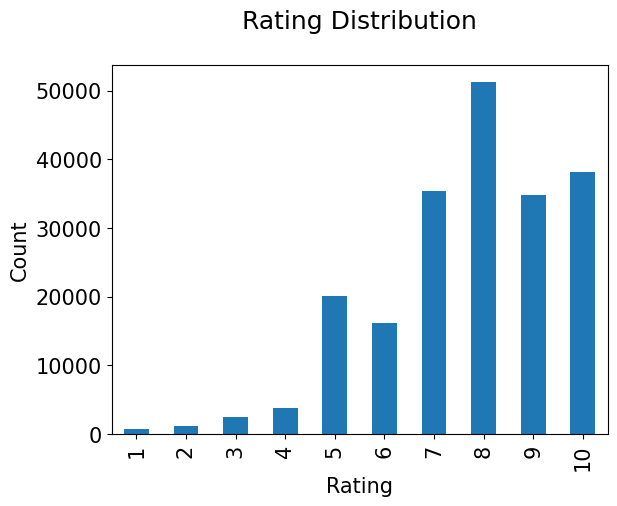

In [126]:
# Count the occurrences of each rating, sort the index (rating values), and then plot
plt.rc("font", size=15)
ratings_df['Book-Rating'].value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

Users with less than 50 ratings and books with less than 10 ratings are excluded.

In [ ]:
counts1 = ratings_df['User-ID'].value_counts()
ratings_df2 = ratings_df[ratings_df['User-ID'].isin(counts1[counts1 >= 50].index)]
counts = ratings_df2['Book-Rating'].value_counts()
ratings2 = ratings_df2[ratings_df2['Book-Rating'].isin(counts[counts >= 10].index)]
print("Number of eligible users:", len(ratings))

## Nearest Neighbors

In [ ]:
# Note: This section of code was created separately and may have certain discrepancies

## Implementation

In [132]:
from scipy.sparse import csr_matrix

# Create pivot table and matrix from cleaned dataframa
df = df.drop_duplicates(['User-ID', 'Book-Title'])
df_pivot = df.pivot(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
df_matrix = csr_matrix(df_pivot.values)

from sklearn.neighbors import NearestNeighbors

# Create and fit NearestNeighbours model
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(df_matrix)
print(model_knn)

NearestNeighbors(algorithm='brute', metric='cosine')


In [135]:
# Create a random query from the pivot table
query_index = np.random.choice(df_pivot.shape[0])
print(query_index)
print(df_pivot.iloc[query_index,:].values.reshape(1,-1))

# Extract the distances and title from the queried book
distances, indices = model_knn.kneighbors(df_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)
df_pivot.index[query_index]

14492
[[0. 0. 0. ... 0. 0. 0.]]


'Your Baby and Child: From Birth to Age Five'

In [134]:
# Generate a list of 5 recommended books nearest to the queried book
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(df_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, df_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The Sneetches and Other Stories:

1: Secrets of the Cube : The Ancient Visualization Games That Reveals Your True Self, with distance of 0.4427217874246472:
2: Bhagavad Gita (Penguin Classics), with distance of 0.5544336056604966:
3: The Canterbury Tales (Oxford Paperbacks), with distance of 0.5885244001010883:
4: The Time Machine (Bantam Classics), with distance of 0.6301022785629462:
5: Bhagavadgita (Dover Thrift Editions), with distance of 0.6475327975054193:
